#Project Overview

# **The Data**


**Features - Spectral Energy Distribution**

A spectral energy distribution (SED) shows how the energy output of a galaxy is distributed across the electromagnetix spectrum. This tells us how bright a galaxy is at each particular wavelength.

Each component of a galaxy leaves a specific imprint on the SED.




**Targets**


Each of these targets impacts the SED differently






1.   **Age**
2. **Stellar Mass**
3. **Dust (A_v)**

When dust is present, some of the ultraviolet and blue optical light is absorbed and re-emitted in the infared. The "spikes" in the SED are caused by polycyclic aromatic hydrocarbons (PAHs), which give important clues about the structures of dust in a galaxy.

Dust can cause ambiguity when predicting the age of a galaxy. A young but dusty galaxy appears red, but so does an old and clear galaxy. Both of these have significant infared outputs.


Each of these targets impacts the SED differently.


**The Goal**

Use various machine learning algorithms to predict each target based on the spectral data. Diagnose, optimize, and repeat!

Conclude with challenges and results.


#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing, decomposition
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import sklearn
import math

In [ ]:
properties = pd.read_csv('https://raw.githubusercontent.com/hannahestauss/Happiness-Analysis-Vis/main/GalaxyProperties.csv')

In [ ]:
spectra = pd.read_csv('https://raw.githubusercontent.com/hannahestauss/Happiness-Analysis-Vis/main/spectra.csv', delimiter=" ", header=None)

#Exploration

In [ ]:
properties.describe()

In [ ]:
properties.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
spectra

In [ ]:
fig = properties.hist(figsize=(12,12))

In [ ]:
# Assuming 'properties' is your DataFrame with multiple variables including 'Mass'
# Extract the columns you want to normalize (excluding 'Mass')
columns_to_normalize = properties.columns.difference(['Log10(Mass/Mass_Sun)', 'Dust attenuation value'])

# Normalize the selected columns using Min-Max scaling
properties_normalized = (properties[columns_to_normalize] - properties[columns_to_normalize].min()) / (properties[columns_to_normalize].max() - properties[columns_to_normalize].min())

# Add the 'Mass' column back to the normalized DataFrame
properties_normalized['Log10(Mass/Mass_Sun)'] = properties['Log10(Mass/Mass_Sun)']
properties_normalized['Dust attenuation value'] = properties['Dust attenuation value']

In [ ]:
from scipy.stats import boxcox
dust_attenuation = properties['Dust attenuation value'].values

transformed_data, lambda_value = boxcox(dust_attenuation)
properties['Dust attenuation value'] = transformed_data

In [ ]:
#properties['Dust attenuation value'] = boxcox(properties['Dust attenuation value'])
properties['Tau (Gyr)'] = np.log(properties['Tau (Gyr)'])
properties['Age (Gyr)'] = np.log(properties['Age (Gyr)'])

In [ ]:
fig = properties.hist(figsize=(12,12))

From these, I predict that dust and Tau will likely be the most difficult properties to predict. The only normally distributed value is Solar Mass, while the age graph seems to be only the right half of a normal distribution.

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
Age = properties['Age (Gyr)']
TAU = properties['Tau (Gyr)']
DAT = properties['Dust attenuation value']
Mass = properties['Log10(Mass/Mass_Sun)']
targets = [Age, TAU, DAT, Mass]
for x in targets:
  x = le.fit_transform(x)

In [ ]:
scaler = preprocessing.StandardScaler()
scalespec = scaler.fit_transform(spectra)

In [ ]:
scalespecdf = pd.DataFrame(scalespec)

#Learning Curve Function

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'neg_mean_squared_error', scale = False):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("# of training examples",fontsize = 14)

    plt.ylabel("Score",fontsize = 14)

    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#   plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    plt.legend(loc="best",fontsize = 12)
    return plt

In [ ]:
def accplot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("# of training examples",fontsize = 14)

    plt.ylabel("Score",fontsize = 14)

    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#   plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    plt.legend(loc="best",fontsize = 12)
    return plt

#Model to predict Stellar Mass

In [ ]:
model = RandomForestRegressor()

In [ ]:
scores = cross_validate(model,scalespecdf,DAT, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
ypred = cross_val_predict(model,scalespecdf, DAT, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
len(np.where(np.abs(Mass-ypred)>0.15*(1+Mass))[0])/len(Mass)

1.0

In [ ]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 500, replace = False) #sample without replacement

In [ ]:
seld = scalespecdf.loc[sel,:]
selt = Mass[sel]

In [ ]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

(0.9616913866621442, 0.9942780577255419)

In [ ]:
parameters = {'min_impurity_decrease':[0.1, 0.5, 0.0], \
              'max_features':[None,600,400], 'n_estimators':[50, 100, 200], 'min_samples_split': [10,20,100]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params, best score: 0.9499 {'max_features': 400, 'min_impurity_decrease': 0.0, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
74,"{'max_features': 400, 'min_impurity_decrease':...",0.949903,0.012068,0.985013
72,"{'max_features': 400, 'min_impurity_decrease':...",0.949842,0.012594,0.984309
47,"{'max_features': 600, 'min_impurity_decrease':...",0.949525,0.011608,0.984879
19,"{'max_features': None, 'min_impurity_decrease'...",0.949289,0.012234,0.984793
45,"{'max_features': 600, 'min_impurity_decrease':...",0.949276,0.011634,0.984614
...,...,...,...,...
39,"{'max_features': 600, 'min_impurity_decrease':...",-0.020944,0.015770,-0.000039
10,"{'max_features': None, 'min_impurity_decrease'...",-0.020992,0.014584,-0.000039
36,"{'max_features': 600, 'min_impurity_decrease':...",-0.021005,0.014129,-0.000025
15,"{'max_features': None, 'min_impurity_decrease'...",-0.021197,0.013323,-0.000069


These values are lower than my initial test value, just slightly. This tells me that they wouldn't be useful for optimization. Because the original test values are so high, I'm not too worried about increasing the accuracy.

#Model to predict Dust Attenuation Value

In [ ]:
model = RandomForestRegressor()

In [ ]:
scores = cross_validate(model,scalespecdf,DAT, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

{'fit_time': array([31.81377125, 32.34259677, 31.68871355, 31.65545368, 32.87206769]),
 'score_time': array([0.0163846 , 0.01574135, 0.01564503, 0.01535034, 0.01606536]),
 'test_score': array([0.89593475, 0.85525114, 0.90800889, 0.9032591 , 0.91922014]),
 'train_score': array([0.98528253, 0.98784432, 0.98501129, 0.98557805, 0.98572902])}

In [ ]:
ypred = cross_val_predict(model,scalespecdf, DAT, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
len(np.where(np.abs(DAT-ypred)>0.15*(1+DAT))[0])/len(DAT)

0.951

In [ ]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 750, replace = False) #sample without replacement

In [ ]:
seld = scalespecdf.loc[sel,:]
selt = DAT[sel]

In [ ]:
model = RandomForestRegressor()

In [ ]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

(0.886529596123608, 0.9837536399736349)

In [ ]:
 np.mean(scores['test_score'])

0.8963348038626832

##Optimization



To see if optimization of tree parameters will increase test scores, I decided to run multiple different versions of the model and print out the test scores for each.

This should help to show where any issues may fall, if these paramaters impact the model in a good/bad way, etc. It's a good benchmark for optimization.

In [ ]:
parameters = {'min_impurity_decrease':[0.1, 0.5, 0.0], \
              'max_features':[750,600,None], 'n_estimators':[25,50,75], 'min_samples_split': [5,10,None]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

Best params, best score: 0.8796 {'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_split': 5, 'n_estimators': 75}


In [ ]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
74,"{'max_features': None, 'min_impurity_decrease'...",0.879585,0.027854,0.978309
73,"{'max_features': None, 'min_impurity_decrease'...",0.876906,0.031756,0.976715
19,"{'max_features': 750, 'min_impurity_decrease':...",0.876243,0.031497,0.977414
47,"{'max_features': 600, 'min_impurity_decrease':...",0.873022,0.032182,0.977146
20,"{'max_features': 750, 'min_impurity_decrease':...",0.872508,0.029745,0.977701
...,...,...,...,...
70,"{'max_features': None, 'min_impurity_decrease'...",NaN,NaN,NaN
71,"{'max_features': None, 'min_impurity_decrease'...",NaN,NaN,NaN
78,"{'max_features': None, 'min_impurity_decrease'...",NaN,NaN,NaN
79,"{'max_features': None, 'min_impurity_decrease'...",NaN,NaN,NaN


With these parameters, we are able to get a small increase in our scores. I ran this a few times, tweaking based on the answers I got.

With the estimators set higher and the minimum sample size at 5, the scores increase by about 1 point.

##Feature Selection

In [ ]:
model = RandomForestRegressor(n_estimators=500)
model.fit(seld,selt)

RandomForestRegressor(n_estimators=500)

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
sels = pd.DataFrame(scalespec)

In [ ]:
sels

,0,1,2,3,4,5,6,7,8,9,...,840,841,842,843,844,845,846,847,848,849
0,-0.475163,-0.473604,-0.474694,-0.474607,-0.478174,-0.484576,-0.489828,-0.483696,-0.482570,-0.473944,...,-0.216716,-0.216058,-0.215663,-0.215148,-0.214719,-0.214418,-0.213754,-0.212460,-0.211325,-0.210914
1,-0.466753,-0.466174,-0.466116,-0.465827,-0.466203,-0.467439,-0.469383,-0.466919,-0.466717,-0.464607,...,-0.207283,-0.206764,-0.206426,-0.206016,-0.205667,-0.205403,-0.204865,-0.203846,-0.202932,-0.202563
2,-0.509697,-0.509465,-0.508946,-0.508517,-0.507704,-0.507107,-0.507624,-0.506658,-0.506759,-0.506964,...,-0.220173,-0.219515,-0.219131,-0.218596,-0.218146,-0.217825,-0.217147,-0.215866,-0.214743,-0.214292
3,-0.199200,-0.200158,-0.200824,-0.201716,-0.202028,-0.201030,-0.199198,-0.202611,-0.203482,-0.205833,...,-0.204102,-0.203689,-0.203414,-0.203096,-0.202840,-0.202666,-0.202241,-0.201360,-0.200574,-0.200342
4,0.190895,0.187301,0.186190,0.183713,0.185021,0.192503,0.203966,0.187959,0.185364,0.173216,...,-0.195729,-0.195372,-0.195142,-0.194908,-0.194745,-0.194675,-0.194332,-0.193512,-0.192786,-0.192713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.102020,-0.102618,-0.101422,-0.101185,-0.098264,-0.091375,-0.082330,-0.090878,-0.091024,-0.097679,...,-0.123099,-0.123181,-0.123199,-0.123214,-0.123218,-0.123188,-0.123234,-0.123344,-0.123419,-0.123363
996,-0.455463,-0.455163,-0.453691,-0.452757,-0.450094,-0.446363,-0.444385,-0.445013,-0.445004,-0.447863,...,-0.175921,-0.174777,-0.174330,-0.173352,-0.172533,-0.171935,-0.170856,-0.168969,-0.167390,-0.166550
997,0.245249,0.241062,0.240056,0.237343,0.239401,0.248944,0.263195,0.243885,0.240913,0.226047,...,-0.193422,-0.193101,-0.192893,-0.192685,-0.192545,-0.192493,-0.192186,-0.191425,-0.190752,-0.190707
998,-0.401726,-0.401438,-0.401175,-0.400916,-0.400631,-0.400428,-0.400701,-0.400032,-0.399996,-0.399644,...,-0.203466,-0.202917,-0.202584,-0.202147,-0.201780,-0.201512,-0.200954,-0.199887,-0.198941,-0.198569


In [ ]:
print("Feature ranking:")
for f in range(sels.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, sels.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. feature: 760, 760 (0.626864)
2. feature: 6, 6 (0.022781)
3. feature: 759, 759 (0.012855)
4. feature: 1, 1 (0.012143)
5. feature: 5, 5 (0.010008)
6. feature: 0, 0 (0.010003)
7. feature: 4, 4 (0.006436)
8. feature: 2, 2 (0.006171)
9. feature: 3, 3 (0.006000)
10. feature: 758, 758 (0.005056)
11. feature: 7, 7 (0.004681)
12. feature: 307, 307 (0.004458)
13. feature: 761, 761 (0.004400)
14. feature: 8, 8 (0.004153)
15. feature: 400, 400 (0.004008)
16. feature: 348, 348 (0.003759)
17. feature: 445, 445 (0.003635)
18. feature: 490, 490 (0.003537)
19. feature: 17, 17 (0.002998)
20. feature: 12, 12 (0.002788)
21. feature: 554, 554 (0.002742)
22. feature: 402, 402 (0.002578)
23. feature: 10, 10 (0.002494)
24. feature: 13, 13 (0.002488)
25. feature: 467, 467 (0.002487)
26. feature: 409, 409 (0.002464)
27. feature: 385, 385 (0.002145)
28. feature: 344, 344 (0.002126)
29. feature: 381, 381 (0.002023)
30. feature: 26, 26 (0.001839)
31. feature: 497, 497 (0.001772)
32. feature: 11

There isn't too much noise, and none of the features provide nothing for the model. I decided to just keep them.

# Model for age of a galaxy

I suspect this one may be difficult. Based on what I know about dust, I'm thinking that I may add it as a feature if the scores need a boost.

Maybe the model will be able to recognize that larger amounts of dust can impact the amount of infared light emitted by the galaxy.

In [ ]:
model = GradientBoostingRegressor()

In [ ]:
scores = cross_validate(model,scalespec,Age, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

{'fit_time': array([23.48521781, 22.97958636, 21.91340041, 23.10194468, 23.180053  ]),
 'score_time': array([0.00217319, 0.00284123, 0.00197864, 0.0022347 , 0.00255489]),
 'test_score': array([0.57545216, 0.49668981, 0.53288035, 0.47478409, 0.59267523]),
 'train_score': array([0.84017538, 0.85800013, 0.85348139, 0.84982387, 0.83948998])}

In [ ]:
scores

{'fit_time': array([23.48521781, 22.97958636, 21.91340041, 23.10194468, 23.180053  ]),
 'score_time': array([0.00217319, 0.00284123, 0.00197864, 0.0022347 , 0.00255489]),
 'test_score': array([0.57545216, 0.49668981, 0.53288035, 0.47478409, 0.59267523]),
 'train_score': array([0.84017538, 0.85800013, 0.85348139, 0.84982387, 0.83948998])}

In [ ]:
model = RandomForestRegressor()

In [ ]:
ypred = cross_val_predict(model,spectra, Age, cv = KFold(n_splits=5, shuffle=True, random_state=10))

(-3.2067787217951267,
 1.8387025531684937,
 -2.3922202548851086,
 2.653261020078512)

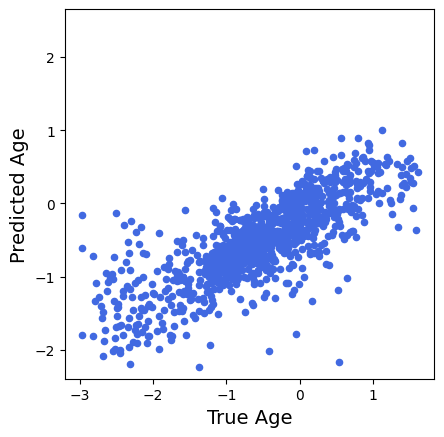

In [ ]:
plt.scatter(Age,ypred, s = 20, c = 'royalblue')
plt.xlabel('True Age', fontsize=14)
plt.ylabel('Predicted Age',fontsize=14)
plt.axis('square')

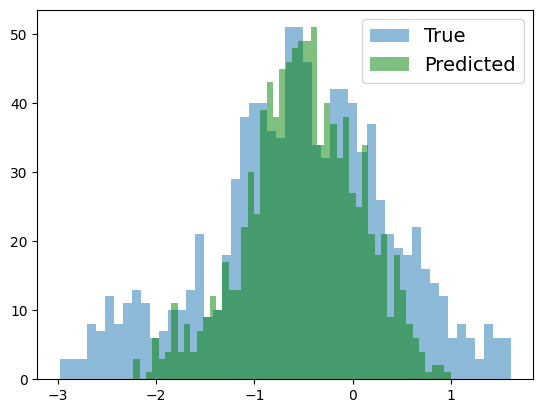

In [ ]:
plt.hist(Age,bins=50,density=False,alpha=0.5, label = 'True');
plt.hist(ypred,bins=50,density=False,alpha=0.5, color = 'g', label = 'Predicted');
plt.legend(fontsize=14);

The model appears to suffer from both high bias and high variance. To begin optimizing, I'll run the same grid search a few times and try to optimize the paramaters.

In [ ]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 500, replace = False) #sample without replacement

In [ ]:
sels = spectra.loc[sel,:]
selt = Age[sel]

In [ ]:
seld = scaler.fit_transform(sels)

In [ ]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

(0.5272010284623612, 0.9313391194163391)

In [ ]:
parameters = {'min_impurity_decrease':[0.1, 0.5, 0.0], \
              'max_features':[750,600,None], 'n_estimators':[75,100,125], 'min_samples_split': [5,2, None]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

##Adding Dust as a feature

I chose to add dust and see what happens to the model because of how dust can impact the spectra.

As explained earlier, dust can impact galaxies by inceasing the appearance of infared light. The light from younger galaxies is fiktered through dust and more of it appears red, much like he light from clearer, older galaxies. I figure, if the model can learn this, maybe it will be able to more accurately predict the age of the galaxies. Higher dust values means the infared light wouldn't necessarily indicate old age.

In [ ]:
dustspec = spectra.copy()

In [ ]:
dustspec['dust'] = DAT

In [ ]:
seld = dustspec.loc[sel,:]
selt = Age[sel]

In [ ]:
model = RandomForestRegressor(n_estimators=500)

In [ ]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

ValueError: ignored

In [ ]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

I saw a little bit of improvement when adding dust as a feature, but the model still could be better.

In [ ]:
parameters = {'min_impurity_decrease':[0.1, 0.5, 0.0], \
              'max_features':[750,600,None], 'n_estimators':[125,250,500]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(GradientBoostingRegressor(), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(seld,selt)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

It looks like the only estimator that helped in the grid search was increasing the number of estimators. Lastly, I'll try to look at the feature importance and see if that's what's causing issues.

In [ ]:
model = GradientBoostingRegressor(n_estimators=500)
model.fit(seld,selt)

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
print("Feature ranking:")
for f in range(seld.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, seld.columns[indices[f]], indices[f], importances[indices[f]]))

The feature importance showed that only 673 features were at all useful in predicting the age, The dust, surprisingly, was very helpful!

In order to reduce the range, I tested out a few values in the following loop. I eventually settled on 550 features.

In [ ]:
selfeat = pd.DataFrame()
for f in range (499):
  selfeat[f]=(seld[f])
selfeat['550'] = seld['dust']

In [ ]:
print(selfeat)

In [ ]:
model = GradientBoostingRegressor(n_estimators=1000)
scores = cross_validate(model,selfeat,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

In [ ]:
scores['test_score'].mean(), scores['train_score'].mean()

In [ ]:
ypred = cross_val_predict(model,selfeat, selt, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
plt.scatter(selt,ypred, s = 20, c = 'royalblue')
plt.xlabel('True Age', fontsize=14)
plt.ylabel('Predicted Age',fontsize=14)
plt.axis('square')

## Using log(Age) in place of the original values

In [ ]:
LAge = np.log(Age)

In [ ]:
ypred = cross_val_predict(model,spectra, LAge, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
np.random.seed(20)
sel = np.random.choice(range(len(ypred)), 500, replace = False) #sample without replacement

In [ ]:
sels = dustspec.loc[sel,:]
selt = LAge[sel]

In [ ]:
sels

In [ ]:
sels.columns = sels.columns.astype(str)
seld = scaler.fit_transform(sels)

In [ ]:
littlescores = cross_validate(model,seld,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

In [ ]:
model = GradientBoostingRegressor(n_estimators=1000)
scores = cross_validate(model,selfeat,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
TAU.describe()

In [ ]:
model = GradientBoostingRegressor()

In [ ]:
scores = cross_validate(model,scalespec,TAU, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

In [ ]:
scores['test_score'].mean(), scores['train_score'].mean()

In [ ]:
ypred = cross_val_predict(model,scalespec, Age, cv = KFold(n_splits=5, shuffle=True, random_state=10))

In [ ]:
plt.scatter(TAU,ypred, s = 20, c = 'royalblue')
plt.xlabel('True TAU', fontsize=14)
plt.ylabel('Predicted TAU',fontsize=14)
plt.axis('square')

In [ ]:
plt.hist(TAU,bins=50,density=False,alpha=0.5, label = 'True');
plt.hist(ypred,bins=50,density=False,alpha=0.5, color = 'g', label = 'Predicted');
plt.legend(fontsize=14);

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
plot_learning_curve(model, 'Generalized Learning Curves', scalespec, TAU, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), cv = KFold(n_splits=5, shuffle=True))

##Little Test

In [ ]:
sels = spectra.loc[sel,:]
selt = TAU[sel]

In [ ]:
seld = scaler.fit_transform(sels)

In [ ]:
model = GradientBoostingRegressor()

In [ ]:
littlescores = cross_validate(model,sels,selt, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
littlescores['test_score'].mean(), littlescores['train_score'].mean()

The test scores on a smaller set are significantly worse, which makes me think that this model might require more data than the others.

In any case, I'll try a few things to get the scores up.

##Ridge Regression for TAU

In [ ]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV

In [ ]:
MSE = []

for alpha in np.logspace(-5,3,9):

    #model_reg = Ridge(alpha = alpha, normalize = True)
    model_reg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=alpha))

    scores = cross_validate(model_reg, scalespec, TAU, cv = KFold(n_splits=10, shuffle=True, random_state = 1), scoring = 'neg_mean_squared_error')

    print(alpha, (-np.mean(scores['test_score'])))

    MSE.append(-np.mean(scores['test_score']))

print('Best alpha:', np.logspace(-5,3,9)[np.argmin(MSE)])

In [ ]:
model = Ridge(alpha = 1e-7, normalize = True)

model.fit(scalespec,TAU)

coef_no_reg =  np.hstack([model.coef_, model.intercept_])

print(coef_no_reg)

In [ ]:
L1000 = Ridge(alpha = 10, max_iter = 1000000, tol = 0.005, normalize=True)

L1000.fit(scalespec, TAU)

coef_L1000 =  np.hstack([L1000.coef_, L1000.intercept_])

In [ ]:
coef_L1000

In [ ]:
model = SVC(C=10)

In [ ]:
scores = cross_validate(model,scalespec,TAU, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

##Feature Selection

In [ ]:
model = GradientBoostingRegressor(n_estimators=500)
model.fit(scalespec, TAU)

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
indices

In [ ]:
sels = pd.DataFrame(scalespec)

In [ ]:
print("Feature ranking:")
for f in range(sels.shape[1]):
    print("%d. feature: %s, %d (%f)" % (f + 1, sels.columns[indices[f]], indices[f], importances[indices[f]]))

657


In [ ]:
scalespecdf = pd.DataFrame(scalespec)

In [ ]:
num

In [ ]:
indices[5]

In [ ]:
selfeat = pd.DataFrame()
for f in range (550):
  targ = indices[f]
  selfeat[f]=(scalespecdf[targ])

In [ ]:
print(selfeat)

In [ ]:
model = GradientBoostingRegressor(n_estimators=1000)
scores = cross_validate(model,selfeat,TAU, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

In [ ]:
scores['test_score'].mean(), scores['train_score'].mean()

Better train scores, worse test scores. Higher variance.

##Adding Features

In [ ]:
tauspec = scalespecdf.copy()

In [ ]:
tauspec['dust'] = DAT
tauspec['age'] = Age

In [ ]:
scaletau = scaler.fit_transform(tauspec)

In [ ]:
scores = cross_validate(model,tauspec,TAU, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)

In [ ]:
scores

In [ ]:
scores['test_score'].mean(), scores['train_score'].mean(

#Sources Used

Dimensionality Reduction - https://stackabuse.com/dimensionality-reduction-in-python-with-scikit-learn/